# Case Study #2: Santa Claus Route Optimization Problem

# Executive Summary:

#### In this MVP, I'm trying to find the optimal route for Santa such that the weight-miles (weight * miles) is as low as possible in his night of sleigh flights. I chose to use the optimization method I mentioned on our group phone call: the Simulated Annealing (SA) algorithm (https://en.wikipedia.org/wiki/Simulated_annealing). It's great for problems like this with a massive search space (Traveling Salesperson and combinatorial optimation-type problems). It won't find the global, best solution, but it'll find a pretty good solution (and in a fraction of the time too). <br><br> Optimizing this route is difficult. There are 100,000 destinations around the world, and if you assume that the sleigh can hold all gifts without the need to return periodically to the North Pole, there are (100,000 - 1)! possible routes to consider.  In this problem, Santa has to periodically return to the North Pole, which means there are even more routes to consider. <br><br> At a high level, when implimenting the SA algorithm, you take an initial route, evaluate it, then randomly perturb the route, and see if it performs any better. In this exercise, I assumed that for every trip out of the North Pole, Santa is carrying as close to 1000 lbs on the sleigh as possible, and for each perturbation in each iteration of the algorithm, I randomly swapped a small amount of gifts around. This way, his night's worth of routes change a bit with each iteration. <br><br> Because this is just intended as a POC and given the limited time, I only ran the algorithm shown below for 100 iterations. This POC shows that the route improves by 0.55% even in a small number of iterations. As this web app demonstrates, simulated annealing can require 100,000s of iterations before dramatic improvements are made: http://toddwschneider.com/posts/traveling-salesman-with-simulated-annealing-r-and-shiny/      <br><br>Given additional time to work on the next version of this MVP, I would have tried: 
    * Instead of perturbing the list of gifts and locations between each trip of 1000 pounds, I could try optimizing the routes within each trip. That is, getting a solution where for each trip of 1000 pounds, he would be traveling in a circle, rather than inefficiently criss-crossing around the world.
    * If I had access to a computer cluster, it would be effortless to speed up the computation here. I wrote this code allowing for parallelizing, so no changes would have to be made and it could run an order of magnitude faster. This would make it feasible to run 100,000s or a few million iterations.


### Library Imports and defining functions

In [1]:
import time
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from geopy.distance import distance # Function to calculate the distance between two coordinatesthe Haversine formula
from matplotlib import pyplot as plt
import matplotlib.gridspec as gs
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None

# I have 4 registered cores to work with on my laptop. I'll use that to speed the calculations up. 
core_count = cpu_count()
print core_count

# Set the random seed
np.random.seed(512)

4


In [2]:
# Function to swap a small number of rows (this is the small perturbation in the overall route that happens with each iteration of the algorithm)
def shuffle_a_few_rows(df, n_swaps):
    """
    df: the dataframe you're working with
    n_swaps: the number swaps you want to do
    """
    for i in range(0, n_swaps):
        loc1 = np.random.randint(0, len(df))
        loc2 = np.random.randint(0, len(df))
        b, c = df.iloc[loc1].copy(), df.iloc[loc2].copy()
        df.iloc[loc1],df.iloc[loc2] = c,b
    return df



# Function that to evaluate the weight-miles (weight * miles) associated with each north pole to houses to north pole trip.
# *This can be parallelized easily*
def evaluate_individual_trip_route(trip_number):
    """
    trip_number: the integer trip number from the route dataframe
    """
    sub_df = new_df.loc[new_df['trip_number'] == trip_number]
    sub_df['shift_Latitude'] = sub_df['Latitude'].shift(-1)
    sub_df['shift_Longitude'] = sub_df['Longitude'].shift(-1)
    #sub_df.loc[sub_df.index[-1], 'shift_Latitude'] = 90
    #sub_df.loc[sub_df.index[-1], 'shift_Longitude'] = 0
    weight_miles = 0
    current_sleigh_weight = sub_df['Weight'].sum() + 10
    weight_miles += (distance(North_Pole, (sub_df['Latitude'].values[0], sub_df['Longitude'].values[0])).miles) * (current_sleigh_weight)
    for row in sub_df.itertuples():
        if np.isnan(row[7]):
            weight_miles += (distance((row[2], row[3]), North_Pole).miles) * (current_sleigh_weight)
        else:
            current_sleigh_weight -= row[4]
            weight_miles += (distance((row[2], row[3]), (row[7], row[8])).miles) * (current_sleigh_weight)
    return weight_miles



### Create an initial random route, and evaluate it

In [3]:
# Create a list to store the results (total weight-miles the whole night) from each iteration
final_results = []

# Setting the north pole latitude and longitude
North_Pole = (90, 0)

### Read in the gifts dataset
gifts = pd.read_csv("~/Desktop/gifts.csv")

# Do an initial shuffling of the dataset
new_df = gifts.sample(frac = 1, random_state = 512).reset_index()[['GiftId', 'Latitude', 'Longitude', 'Weight']]

# Calculate cumulative sum for weights
new_df['cumul_weight'] = new_df['Weight'].cumsum()

# Break up the gifts into trips (trips can't exceed 1000 lbs)
new_df['trip_number'] = new_df['cumul_weight'] / 1000
new_df['trip_number'] = new_df['trip_number'].astype(int)

# Evaluate the overall route, using parallel processing
pool = Pool(processes = core_count)
results = pool.map(evaluate_individual_trip_route, range(0,1410))
pool.close()

# Get the toal weight-miles for that initial, random route. It's terrible, not surprisingly. 
old_result = sum(results)
final_results.append(old_result)

# Set up the old_df variable for the SA algorithm
old_df = new_df.copy()

### Setup the SA hyperparameters (temperature, number of iterations to try, etc.)

In [4]:
temperature = 1.0 # Initial temperature
count = 0 # Start the count at 0
alpha = 0.9995 # The rate at which the temperate will drop over each iteration
iteration_num = 100 # Total number of iterations to stop at

### Run the SA algorithm. A while loop begins here...

In [5]:
while count < iteration_num:
    temperature *= alpha
    count += 1

    ###### Swap 100 (0.1% of all routes) individual routes randomly (https://stackoverflow.com/questions/46890972/swapping-rows-within-the-same-pandas-dataframe)
    new_df = shuffle_a_few_rows(old_df, 10)

    ###### Evaluate the new_dataset

    # Calculate cumulative sum for weights
    new_df['cumul_weight'] = new_df['Weight'].cumsum()

    # Break up the gifts into trips (trips can't exceed 1000 lbs)
    new_df['trip_number'] = new_df['cumul_weight'] / 1000
    new_df['trip_number'] = new_df['trip_number'].astype(int)

    pool = Pool(processes = core_count)
    results = pool.map(evaluate_individual_trip_route, range(0,1410))
    pool.close()

    # Evaluate the new route list 
    new_result = sum(results)

    
    #### Compare new result with old result, decide whether to accept the challenger route as the champion

    if new_result < old_result:
        old_df = new_df.copy()
        old_result = new_result
        p = None
        final_results.append(old_result)

        print "Iteration: {0} \t Temperature: {1} \t P: {2} \t Score: {3}".format(count, temperature, p, old_result)

    else:
        uniform_rand_num = np.random.uniform(0,1)
        p = 1e8 * np.exp(-((np.log(new_result - old_result))/temperature))

        if p > uniform_rand_num:
            old_df = new_df.copy()
            old_result = new_result
            final_results.append(old_result)
            print "Iteration: {0} \t Temperature: {1} \t P: {2} \t Score: {3}".format(count, temperature, p, old_result)
        else:
            print "Iteration: {0} \t Temperature: {1} \t P: {2} \t Score: {3}".format(count, temperature, p, old_result)
            final_results.append(old_result)
            continue


Iteration: 1 	 Temperature: 0.9995 	 P: None 	 Score: 2.89249626279e+11
Iteration: 2 	 Temperature: 0.99900025 	 P: None 	 Score: 2.89239171925e+11
Iteration: 3 	 Temperature: 0.998500749875 	 P: None 	 Score: 2.88902792411e+11
Iteration: 4 	 Temperature: 0.9980014995 	 P: 0.517253958905 	 Score: 2.88902792411e+11
Iteration: 5 	 Temperature: 0.99750249875 	 P: 0.384969918726 	 Score: 2.88902792411e+11
Iteration: 6 	 Temperature: 0.997003747501 	 P: 0.192422144307 	 Score: 2.89392154563e+11
Iteration: 7 	 Temperature: 0.996505245627 	 P: 2.63093349851 	 Score: 2.89427914791e+11
Iteration: 8 	 Temperature: 0.996006993004 	 P: None 	 Score: 2.89072523092e+11
Iteration: 9 	 Temperature: 0.995508989508 	 P: 0.24802243159 	 Score: 2.89072523092e+11
Iteration: 10 	 Temperature: 0.995011235013 	 P: 0.215666371708 	 Score: 2.89072523092e+11
Iteration: 11 	 Temperature: 0.994513729396 	 P: 0.134463953551 	 Score: 2.89072523092e+11
Iteration: 12 	 Temperature: 0.994016472531 	 P: 0.148656708144 	

Iteration: 94 	 Temperature: 0.954076183391 	 P: 0.0216268468474 	 Score: 2.87977284686e+11
Iteration: 95 	 Temperature: 0.953599145299 	 P: 0.0190749211822 	 Score: 2.87977284686e+11
Iteration: 96 	 Temperature: 0.953122345727 	 P: 0.0185969516035 	 Score: 2.87977284686e+11
Iteration: 97 	 Temperature: 0.952645784554 	 P: 0.0238962960655 	 Score: 2.87977284686e+11
Iteration: 98 	 Temperature: 0.952169461662 	 P: 0.0216572392355 	 Score: 2.87977284686e+11
Iteration: 99 	 Temperature: 0.951693376931 	 P: 0.0219966463459 	 Score: 2.87977284686e+11
Iteration: 100 	 Temperature: 0.951217530242 	 P: 0.0284560235701 	 Score: 2.87977284686e+11


Text(0.5,1,' ')

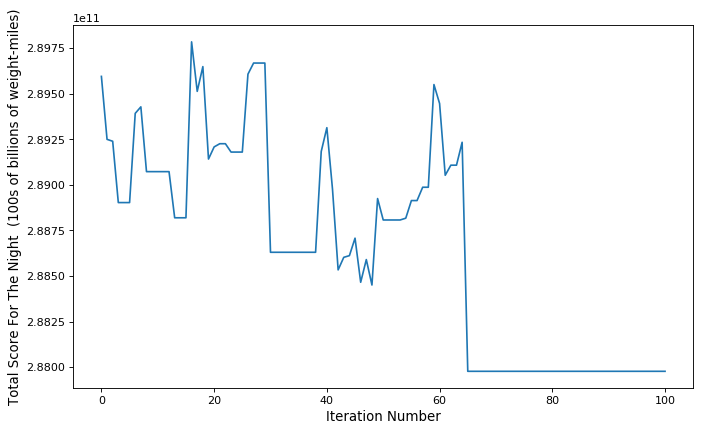

In [6]:
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')

g1 = gs.GridSpec(1,1)

ax1 = plt.subplot(g1[0,0])
plt.plot((final_results))
plt.xlabel('Iteration Number', {'fontsize': 12})
plt.ylabel('Total Score For The Night  (100s of billions of weight-miles)', {'fontsize': 12})
plt.title(' ')